<h1> What Makes a Good Airbnb Listing? </h1>
<h2> Supervised Learning </h2>
<p> <em> New York City, USA </em> </p>

<img src="nyc.png" width=409 height=512 />

<h2>Questions:</h2> <br>
1. Can we predict Airbnb listing price? <br>
2. Can we predict the rating of an Airbnb listing? <br>

<h2>Setup</h2>

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import langid
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect.lang_detect_exception import LangDetectException
from langdetect import detect
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

<h3>Load Data</h3>

In [223]:
listings = pd.read_csv('listings.csv')
sentfeatures = pd.read_csv('sentiment_features.csv')

##Replace NaN values with 0s and convert the price strings into floats, then drop outliers
listings.fillna({'neighborhood_overview':"NoOverview"}, inplace=True)
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings = listings.drop(listings.index[listings['price'] >= 5500])

<h2>Visualize Data</h2>

In [3]:
sns.set_theme()
sns.set_palette("husl", 9) #crest

<h3>Amount of Listings for Each Neighborhood Group</h3>
<p>For NYC, these are the 5 Boroughs: Manhatten, Brooklyn, Queens, Staten Island, and Bronx. As seen in the graph below, a majority of Airbnb listings are found in Manhatten and Brooklyn, the most densely populated/landmark heavy and the city's most populous borough, respectively.</p>

<a href=https://en.wikipedia.org/wiki/Boroughs_of_New_York_City>Boroughs of New York City</a>

<AxesSubplot:xlabel='neighbourhood_group_cleansed', ylabel='Count'>

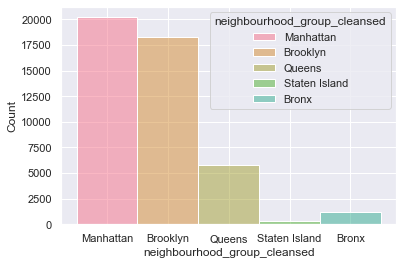

In [4]:
sns.histplot(data=listings, x="neighbourhood_group_cleansed", hue="neighbourhood_group_cleansed")

<h3>Distribution of Listing Prices</h3>
<p>Prices appear to be between <strong>at most</strong> around 2000 USD for a majority of the listings, but there are a small number of more expensive listings as well.</p>

<AxesSubplot:xlabel='price', ylabel='Density'>

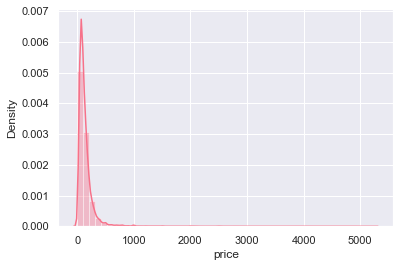

In [5]:
sns.distplot(listings['price'])

<h3>Price Distributions for Each Neighborhood Group</h3>
<p>Manhatten, Brooklyn, and Queens have a more spread out distribution of prices, as opposed to Staten Island and Bronx. Manhatten appears to have many more high-priced listings than the rest, perhaps due to it being a big tourist destination. Staten Island, being the most suburban of the 5, has the fewest and cheapest listings.</p>

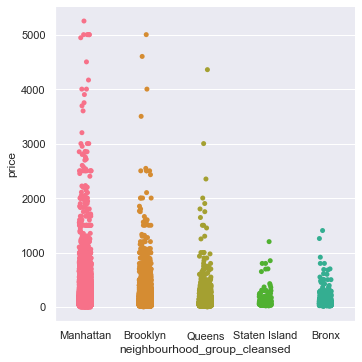

In [6]:
sns.catplot(data=listings, x="neighbourhood_group_cleansed", y="price")

<h3>Price Distributions for Room Type : Each Neighborhood Group</h3>
<p>There are 4 room types: Private rooms, Shared rooms, Entire homes/apartments, and Hotel Rooms. [Hotel rooms are the 4th set of bars, but the axis isn't labeling them for some reason]</p>

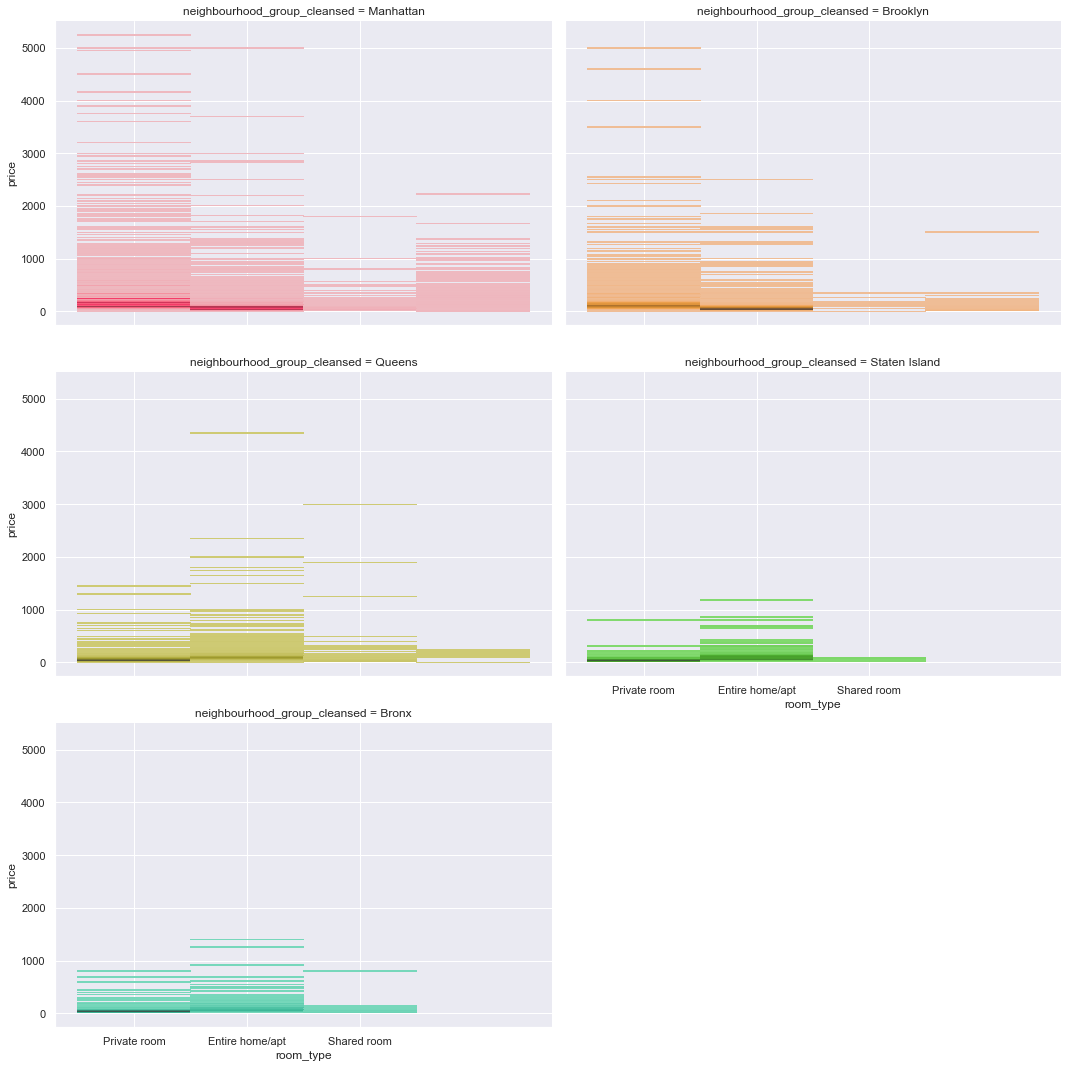

In [7]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=2, height=5, 
                  aspect=1.5, hue="neighbourhood_group_cleansed")
g.map(sns.histplot, "room_type", "price")

<h3>Price Distributions for Accommodation Size : Each Neighborhood Group</h3>
<p>Listing price goes up as the accommodation size goes up.</p>

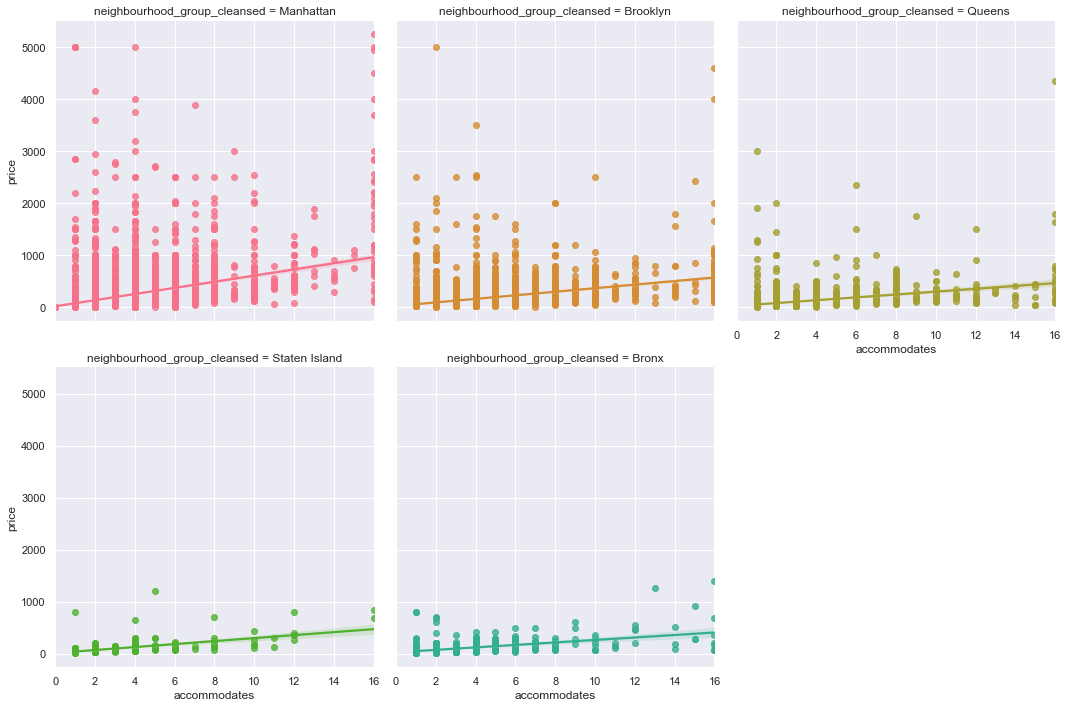

In [8]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=3, height=5, hue="neighbourhood_group_cleansed")
g.map(sns.regplot, "accommodates", "price")

<h2> Clean & Preprocess Data </h2>

<p>Most ML algorithms cannot handle categorical variables unless we convert them to numerical values. Since our data is a mix of numerical and categorical, we go column by column to do the preprocessing.</p>

In [296]:
listings_cleaned_price = listings.copy()
listings_cleaned_price = listings_cleaned_price.rename(columns={"neighbourhood_cleansed": "neighborhood", 
                                                               "neighbourhood_group_cleansed": "neighborhood_group"})

#listings_cleaned_price = sentfeatures.merge(listings_cleaned_price, how="inner", left_on=['listing_id'],right_on=['id'])

<h3>Drop Misc Columns from Data</h3>

In [297]:
# Drop URLs from Dataframe, as they are unlikely to have much influence on prediction results
listings_cleaned_price.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], 
                   axis=1, inplace=True)

# Drop other misc. columns from Dataframe, as they are not too influential on price or are empty/same values
listings_cleaned_price.drop(['id','scrape_id','last_scraped','host_id','host_name',
                             'host_location','host_verifications', 'host_has_profile_pic','neighbourhood',
                             'bathrooms','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                             'minimum_minimum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                             'maximum_nights_avg_ntm','calendar_updated','calendar_last_scraped', 'first_review',
                             'last_review','license','host_is_superhost','instant_bookable'], 
                   axis=1, inplace=True)

<h3> Replace Bathrooms in Text Form with Integer/Float Version </h3>

In [298]:
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('[^\d.]', '', regex=True)
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('', '0.5', regex=True).astype(float)

<h3> Replace List of Amenities with How Many Amenities </h3>

In [299]:
listings_cleaned_price['amenities'] = listings_cleaned_price['amenities'].apply(lambda x: x.strip('][').split(', ')).map(len)

<h3>Replace Neighborhood Overview Feature Values with Text Analysis Values</h3><br>
<a href=https://en.wikipedia.org/wiki/List_of_buildings,_sites,_and_monuments_in_New_York_City>Tourist Attractions in NYC</a><br>
<p>Encoding neighborhood_overview values: Many of the overview texts contain names of famous tourist attractions in NYC. If we construct a word bank of these different locations, then we can replace this column with the number of attractions it's close to, i.e. len of that list</p>

In [300]:
list_of_attractions = ['Empire State Building', 'Brooklyn Bridge', 'Central Park', 'Top of the Rock Observation Deck', 
                       'Statue of Liberty', 'Vessel', 'One World Observatory', 'Metropolitan Museum of Art', 'Chrysler Building',
                       'High Line', 'Broadway', '9/11 Memorial and Museum', 'Rockefeller Center', 'Grand Central Terminal', 'Prospect Park',
                       'Hunters Point Library', 'Brooklyn Museum', 'Whitney Museum of American Art', 'Bronx Zoo', 'Times Square',
                       'Citi Field', 'Yankee Stadium', 'Smorgasburg', 'Apollo Theater', 'Macy’s Herald Square', 'Union Square',
                       'Intrepid Sea, Air & Space Museum', 'United Nations Headquarters', 'Carnegie Hall', 'New York Stock Exchange',
                       'MetLife Building', 'Botanic Gardens', 'Brooklyn Public Library', 'East Village', 'West Village', 'points of interest']

list_of_attractions = [x.lower() for x in list_of_attractions]

for i, listing in listings_cleaned_price.iterrows():
    text = listings_cleaned_price.at[i, 'neighborhood_overview'].lower()
    count = len([loc for loc in list_of_attractions if loc in text])
    listings_cleaned_price.at[i, 'neighborhood_overview'] = count


<h3>Replace Name and Description Feature Text with Sentiment Analysis Values</h3><br>

In [71]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [72]:
def stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def grammar(string):
    # add whatever else you think you might have to account for
    result = str(string)
    result = result.replace('/', ' ')
    result = result.replace('*', ' ')
    result = result.replace('&', ' ')
    result = result.replace('>', ' ')
    result = result.replace('<', ' ')
    result = result.replace('-', ' ')
    result = result.replace('...', ' ')
    result = result.replace('@', ' ')
    result = result.replace('#', ' ')
    result = result.replace('-', ' ')
    result = result.replace('$', ' ')
    result = result.replace('%', ' ')
    result = result.replace('+', ' ')
    result = result.replace('=', ' ')
    return result

def to_single_string(list_of_strings):
    return " ".join(list_of_strings)

In [73]:
names = listings_cleaned_price['name'].astype(str)
descriptions = listings_cleaned_price['description'].astype(str)

In [74]:
name_gram = names.apply(grammar)
descp_gram = descriptions.apply(grammar)
langid.set_languages(['en', 'es', 'zh'])
not_en_title = []
not_en_index_title = []
not_en_descp = []
not_en_descp_index = []

i = 0
for title in name_gram:
    if langid.classify(title)[0] != 'en':
        not_en_title += [title]
        not_en_index_title += [name_gram.index[i]]
    i += 1
    
i = 0
for descp in descp_gram:
    if langid.classify(descp)[0] != 'en':
        not_en_descp += [descp]
        not_en_descp_index+=[descp_gram.index[i]]
    i += 1

In [75]:
for i in name_gram.index:
    if name_gram[i] in not_en_title:
        name_gram[i] = ''
names = name_gram.apply(stop_words)

for i in descp_gram.index:
    if descp_gram[i] in not_en_descp:
        descp_gram[i] = ''
descriptions = descp_gram.apply(stop_words)

descriptions = descriptions.apply(to_single_string)
names = names.apply(to_single_string)

In [76]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_score(string):
    result = sentiment_analyzer.polarity_scores(string)
    return result

def compound_score(sent):
    return sent.get('compound')

def polarity(sent):
    compound = sent.get('compound')
    if(compound >= 0.05):
        return 1
    elif(compound <= -0.05):
        return -1
    return 0

sentiment_names = names.apply(sentiment_score)
sentiment_descriptions = descriptions.apply(sentiment_score)

sentiment_names_m1 = sentiment_names.apply(compound_score)
sentiment_descriptions_m1 = sentiment_descriptions.apply(compound_score)

sentiment_names_m2 = sentiment_names.apply(polarity)
sentiment_descriptions_m2 = sentiment_descriptions.apply(polarity)

In [77]:
listings_cleaned_price['sent_names_m1'] = sentiment_names_m1
listings_cleaned_price['sent_names_m2'] = sentiment_names_m2
listings_cleaned_price['sent_descp_m1'] = sentiment_descriptions_m1
listings_cleaned_price['sent_descp_m2'] = sentiment_descriptions_m2

listings_cleaned_price.drop(columns = ['name', 'description'], inplace = True)

<h3>Convert rest of the categorical variables into dummy/indicator variables.</h3> <br>
<a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html>sklearn.preprocessing.LabelEncoder Documentation </a><br>
<a href=https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html>pandas.get_dummies Documentation</a><br>

<p> We can discuss preferences between the two, if needed. </p>

In [301]:
le = preprocessing.LabelEncoder()  

listings_cleaned_price['neighborhood_group'] = le.fit_transform(listings_cleaned_price['neighborhood_group'].astype(str))
listings_cleaned_price['neighborhood'] = le.fit_transform(listings_cleaned_price['neighborhood'].astype(str))
listings_cleaned_price['room_type'] = le.fit_transform(listings_cleaned_price['room_type'].astype(str))
listings_cleaned_price['property_type'] = le.fit_transform(listings_cleaned_price['property_type'].astype(str))
listings_cleaned_price['has_availability']=le.fit_transform(listings_cleaned_price['has_availability'].astype(str))

listings_cleaned_price['name'] = le.fit_transform(listings_cleaned_price['name'].astype(str))
listings_cleaned_price['description'] = le.fit_transform(listings_cleaned_price['description'].astype(str))
listings_cleaned_price['host_since'] = le.fit_transform(listings_cleaned_price['host_since'].astype(str))
listings_cleaned_price['host_about'] = le.fit_transform(listings_cleaned_price['host_about'].astype(str))
listings_cleaned_price['host_response_time'] = le.fit_transform(listings_cleaned_price['host_response_time'].astype(str))
listings_cleaned_price['host_response_rate'] = le.fit_transform(listings_cleaned_price['host_response_rate'].astype(str))
listings_cleaned_price['host_acceptance_rate'] = le.fit_transform(listings_cleaned_price['host_acceptance_rate'].astype(str))
listings_cleaned_price['host_neighbourhood'] = le.fit_transform(listings_cleaned_price['host_neighbourhood'].astype(str))
listings_cleaned_price['host_identity_verified'] = le.fit_transform(listings_cleaned_price['host_identity_verified'].astype(str))

# listings_cleaned_price['neighborhood_overview'] = le.fit_transform(listings_cleaned_price['neighborhood_overview'].astype(str))
# listings_cleaned_price['bathrooms_text'] = le.fit_transform(listings_cleaned_price['bathrooms_text'].astype(str))
# listings_cleaned_price['amenities'] = le.fit_transform(listings_cleaned_price['amenities'].astype(str))

<h3> Save New CSV </h3>

In [302]:
listings_cleaned_price.to_csv('listings_cleaned_price.csv', index=False)

<h2>Linear Regression</h2>

In [251]:
listings_cleaned_price = pd.read_csv('listings_cleaned_price.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Root mean squared error: 170.12
Coefficient of determination: 0.22

k = 2
Root mean squared error: 150.60
Coefficient of determination: 0.27

k = 3
Root mean squared error: 103.71
Coefficient of determination: 0.40

k = 4
Root mean squared error: 113.76
Coefficient of determination: 0.40

k = 5
Root mean squared error: 132.17
Coefficient of determination: 0.25

k = 6
Root mean squared error: 107.43
Coefficient of determination: 0.40

k = 7
Root mean squared error: 126.55
Coefficient of determination: 0.34

k = 8
Root mean squared error: 133.06
Coefficient of determination: 0.36

k = 9
Root mean squared error: 124.49
Coefficient of determination: 0.34

k = 10
Root mean squared error: 129.03
Coefficient of determination: 0.28



<AxesSubplot:>

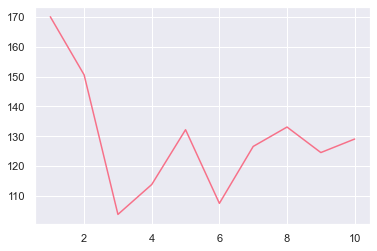

In [252]:
best_lr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    lr = LinearRegression()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train, y_train)
    
    y_preds = np.round(lr.predict(X_test), decimals=2)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_lr_idx[0] = train_index
        best_lr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [253]:
lr = LinearRegression()

train_index, test_index = best_lr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

lr.fit(X_train, y_train)
y_preds = np.round(lr.predict(X_test), decimals=2)

Predicted Price Range:  -66.14 845.62
Actual Price Range:  10.0 1999.0


,Actual Values,Predicted Values
0,75.0,72.89
1,75.0,63.17
2,110.0,115.56
3,83.0,35.75
4,79.0,89.02
5,55.0,72.67
6,350.0,242.15
7,105.0,171.28
8,122.0,132.31
9,220.0,474.73


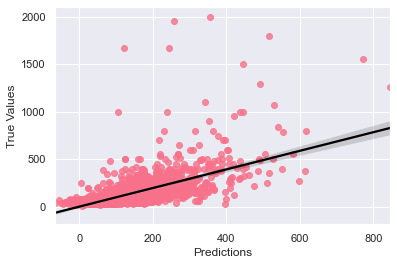

In [254]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

<h3>Get Feature Importances</h3><br>
<p>We can fit a LinearRegression model on the regression dataset and retrieve the coef_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.</p>

longitude -407.4573209858593
room_type -39.64836113992782
review_scores_value -11.301180971924877
calculated_host_listings_count_shared_rooms -9.90505431358708
beds -8.224818896113208
host_response_time -6.515948306596993
review_scores_checkin -4.776235441431641
calculated_host_listings_count_entire_homes -4.487659191699049
calculated_host_listings_count_private_rooms -4.441916990507911
review_scores_accuracy -3.4075660778836787
review_scores_communication -2.4365536224188107
reviews_per_month -2.3918040467787196
number_of_reviews_l30d -2.3745257688953667
number_of_reviews_ltm -0.3131710054260523
availability_90 -0.26802226067519774
minimum_nights -0.17697732238856573
number_of_reviews -0.0823652680305927
host_response_rate -0.08114786523903769
host_acceptance_rate -0.07461474720395286
host_since -0.004224403466208071
description -9.148852948634195e-05
host_about -8.087752450470997e-05
maximum_nights 2.251916588524961e-06
name 0.00018896294035776684
host_neighbourhood 0.001343262838741

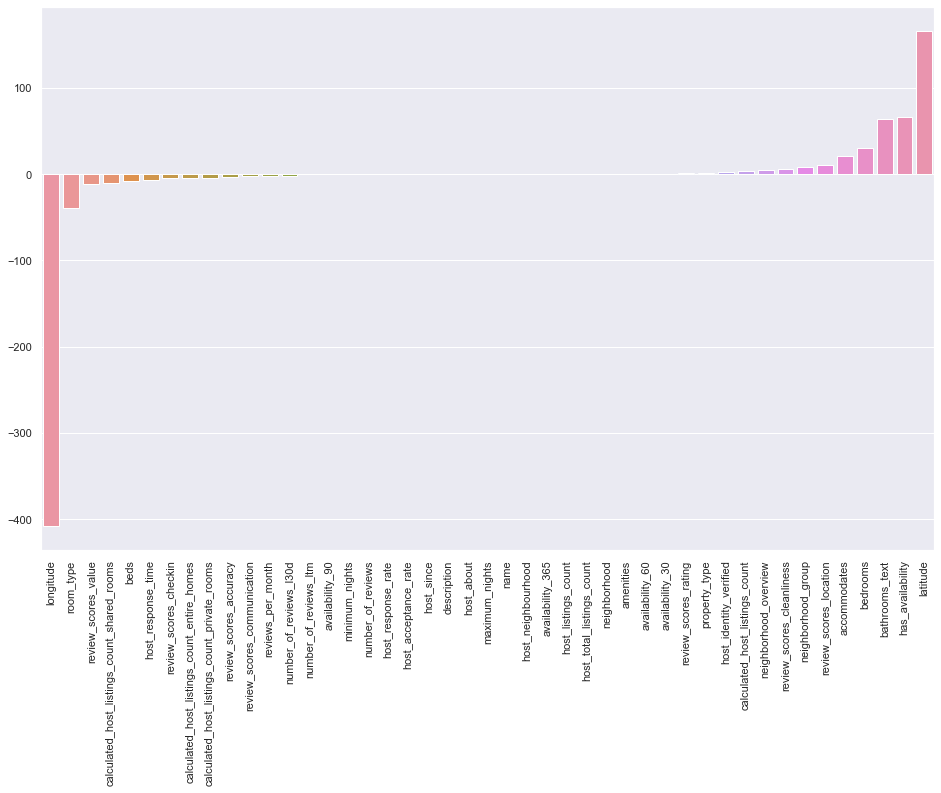

In [119]:
# get importance
importance = lr.coef_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    #print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
for k, v in sorted_imp:
    print(k, v)
# plot feature importance
fig = plt.gcf()
fig.set_size_inches( 16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Random Forest Regressor</h2>

In [2]:
listings_cleaned_price = pd.read_csv('listings_cleaned_price.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Mean absolute error: 46.99
Root mean squared error: 153.81
Coefficient of determination: 0.36

k = 2
Mean absolute error: 43.49
Root mean squared error: 117.98
Coefficient of determination: 0.55

k = 3
Mean absolute error: 43.97
Root mean squared error: 98.33
Coefficient of determination: 0.46

k = 4
Mean absolute error: 45.41
Root mean squared error: 118.54
Coefficient of determination: 0.35

k = 5
Mean absolute error: 44.87
Root mean squared error: 131.49
Coefficient of determination: 0.26

k = 6
Mean absolute error: 43.82
Root mean squared error: 95.01
Coefficient of determination: 0.53

k = 7
Mean absolute error: 43.75
Root mean squared error: 112.43
Coefficient of determination: 0.48

k = 8
Mean absolute error: 42.71
Root mean squared error: 106.48
Coefficient of determination: 0.59

k = 9
Mean absolute error: 41.65
Root mean squared error: 115.04
Coefficient of determination: 0.44

k = 10
Mean absolute error: 45.41
Root mean squared error: 114.53
Coefficient of determinatio

<AxesSubplot:>

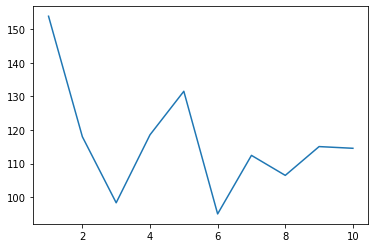

In [3]:
best_regr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    regr = RandomForestRegressor(random_state=42)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    regr.fit(X_train, y_train)
    
    y_preds = np.round(regr.predict(X_test), decimals=2)
    mae = mean_absolute_error(y_test, y_preds)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean absolute error
    print('Mean absolute error: %.2f' % mae)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_regr_idx[0] = train_index
        best_regr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [4]:
regr = RandomForestRegressor(random_state=42)

train_index, test_index = best_regr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

regr.fit(X_train, y_train)
y_preds = np.round(regr.predict(X_test), decimals=2)

Predicted Price Range:  22.34 1349.82
Actual Price Range:  0.0 2200.0


,Actual Values,Predicted Values
0,160.00,223.33
1,239.29,148.01
2,70.00,100.60
3,86.00,85.05
4,130.00,139.45
5,120.00,189.87
6,153.00,162.21
7,150.43,164.06
8,100.00,343.56
9,65.00,126.15


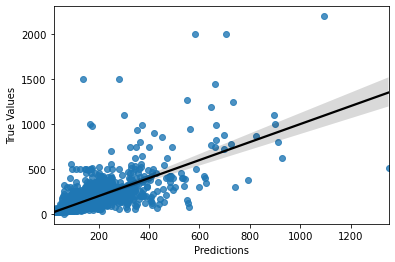

In [5]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

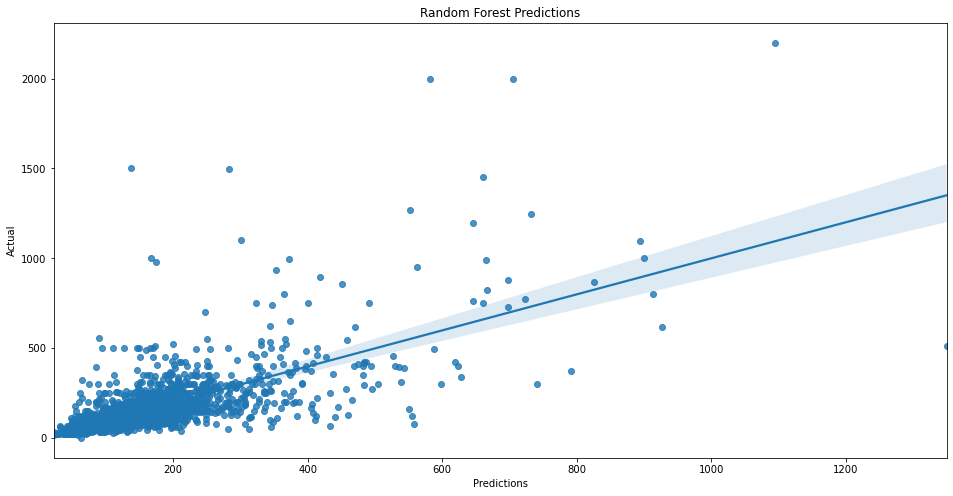

In [7]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group', title="NYC - Random Forest price predictions", yaxis = dict(title ="Price"), xaxis =dict(title="Index"))
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Random Forest Predictions")
plt.show()

<h3>Get Feature Importances</h3><br>
<p>We can fit a RandomForestRegressor model on the regression dataset and retrieve the feature_importances_ property.
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.</p>

Feature 0: name, Score: 0.02572
Feature 1: description, Score: 0.02618
Feature 2: neighborhood_overview, Score: 0.00707
Feature 3: host_since, Score: 0.03530
Feature 4: host_about, Score: 0.02642
Feature 5: host_response_time, Score: 0.00721
Feature 6: host_response_rate, Score: 0.01069
Feature 7: host_acceptance_rate, Score: 0.01827
Feature 8: host_neighbourhood, Score: 0.02040
Feature 9: host_listings_count, Score: 0.01469
Feature 10: host_total_listings_count, Score: 0.01017
Feature 11: host_identity_verified, Score: 0.00249
Feature 12: neighborhood, Score: 0.01415
Feature 13: neighborhood_group, Score: 0.00158
Feature 14: latitude, Score: 0.05792
Feature 15: longitude, Score: 0.07043
Feature 16: property_type, Score: 0.01717
Feature 17: room_type, Score: 0.11368
Feature 18: accommodates, Score: 0.06415
Feature 19: bathrooms_text, Score: 0.14793
Feature 20: bedrooms, Score: 0.01800
Feature 21: beds, Score: 0.01226
Feature 22: amenities, Score: 0.02672
Feature 23: minimum_nights, Sco

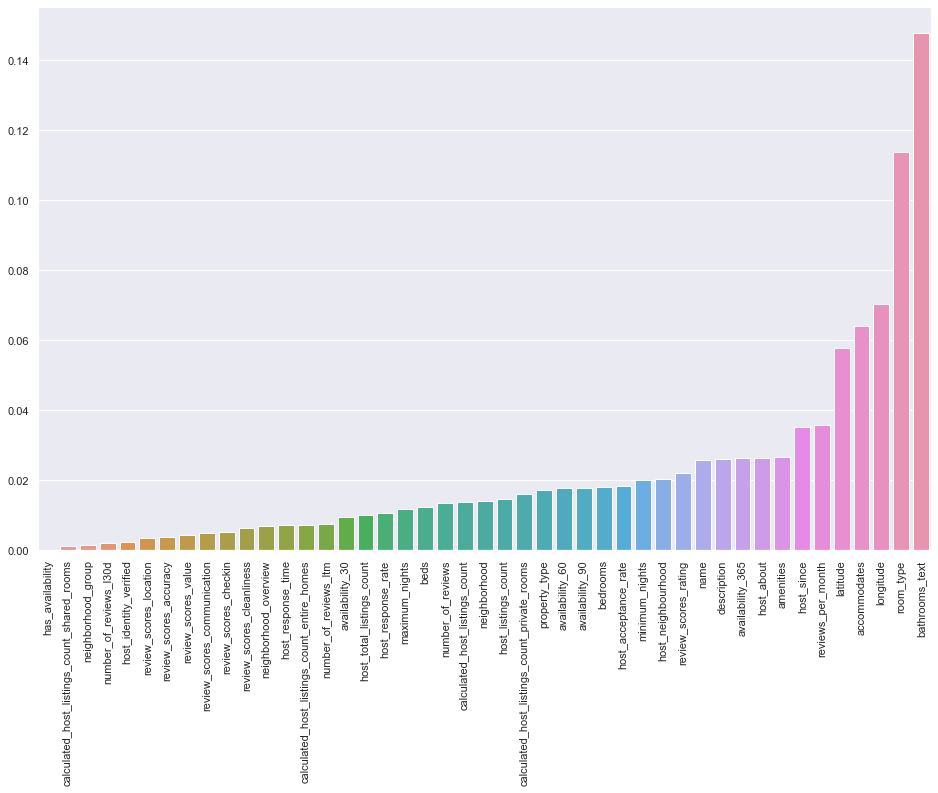

In [113]:
# get importance
importance = regr.feature_importances_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
# plot feature importance
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Neural Network - Price Only</h2>

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [9]:
listings_cleaned_price = pd.read_csv('listings_cleaned_price.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

listings_cleaned_price

,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_neighbourhood,host_listings_count,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1,42741,11970,1,8,14773,4,71,94,73,1.0,...,9.0,9.0,9.0,9.0,9.0,1,1,0,0,4.82
3,35868,39688,0,14,17570,3,2,98,169,1.0,...,10.0,10.0,10.0,8.0,10.0,1,1,0,0,0.01
4,22611,26559,0,22,11370,3,2,2,175,1.0,...,7.0,9.0,9.0,10.0,9.0,1,0,1,0,3.42
5,13609,25182,0,15,19364,1,77,98,415,1.0,...,10.0,10.0,10.0,10.0,10.0,1,0,1,0,0.88
6,15820,18908,0,16,10621,3,2,15,226,4.0,...,9.0,10.0,10.0,9.0,9.0,4,2,0,2,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45538,24255,14660,0,1301,3439,4,2,81,116,1.0,...,10.0,10.0,10.0,10.0,10.0,5,1,3,1,1.00
45566,36791,15694,0,3939,20198,1,77,2,461,0.0,...,10.0,10.0,10.0,10.0,10.0,1,1,0,0,1.00
45568,13646,4153,1,1668,276,4,2,90,449,0.0,...,6.0,10.0,6.0,10.0,10.0,2,0,2,0,1.00
45576,24920,28959,0,1772,4627,4,2,71,10,1.0,...,10.0,10.0,10.0,10.0,10.0,1,1,0,0,1.00


In [10]:
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(listings_cleaned_price.copy())

# multiplied_by = scaler.scale_[13]
# added = scaler.min_[13]

# X = pd.DataFrame(X, columns=listings_cleaned_price.columns.values)
X = listings_cleaned_price.copy()
y = X.pop('price')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                2070      
_________________________________________________________________
dense_1 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [13]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
766/766 [==============================] - 0s 595us/step - loss: 163247872.0000 - mean_squared_error: 163247872.0000
Epoch 2/100
766/766 [==============================] - 0s 560us/step - loss: 381022144.0000 - mean_squared_error: 381022144.0000
Epoch 3/100
766/766 [==============================] - 0s 505us/step - loss: 544626176.0000 - mean_squared_error: 544626176.0000
Epoch 4/100
766/766 [==============================] - 0s 501us/step - loss: 200237824.0000 - mean_squared_error: 200237824.0000
Epoch 5/100
766/766 [==============================] - 0s 512us/step - loss: 284727680.0000 - mean_squared_error: 284727680.0000
Epoch 6/100
766/766 [==============================] - 0s 499us/step - loss: 1014044672.0000 - mean_squared_error: 1014044672.0000
Epoch 7/100
766/766 [==============================] - 0s 504us/step - loss: 486572928.0000 - mean_squared_error: 486572928.0000
Epoch 8/100
766/766 [==============================] - 0s 512us/step - loss: 899244608.0000 - m

766/766 [==============================] - 0s 509us/step - loss: 17442.9941 - mean_squared_error: 17442.9941
Epoch 67/100
766/766 [==============================] - 0s 499us/step - loss: 17463.9766 - mean_squared_error: 17463.9766
Epoch 68/100
766/766 [==============================] - 0s 512us/step - loss: 17448.8477 - mean_squared_error: 17448.8477
Epoch 69/100
766/766 [==============================] - 0s 519us/step - loss: 20219.0586 - mean_squared_error: 20219.0586
Epoch 70/100
766/766 [==============================] - 0s 518us/step - loss: 58515.3203 - mean_squared_error: 58515.3203
Epoch 71/100
766/766 [==============================] - 0s 538us/step - loss: 17661.8984 - mean_squared_error: 17661.8984
Epoch 72/100
766/766 [==============================] - 0s 500us/step - loss: 17484.8848 - mean_squared_error: 17484.8848
Epoch 73/100
766/766 [==============================] - 0s 509us/step - loss: 17476.1250 - mean_squared_error: 17476.1250
Epoch 74/100
766/766 [===============

In [14]:
y_preds = np.round(nn.predict(X_test), decimals=2)

# y_preds -= added
# y_preds /= multiplied_by

# y_test -= added
# y_test /= multiplied_by

Predicted Price Range:  75.96 865.64
Actual Price Range:  17.0 5000.0


,Actual Values,Predicted Values
0,76.0,198.520004
1,219.0,272.880005
2,185.0,173.479996
3,65.0,110.160004
4,126.0,287.119995
5,100.0,148.720001
6,40.0,77.489998
7,400.0,361.399994
8,39.0,75.959999
9,45.0,75.959999


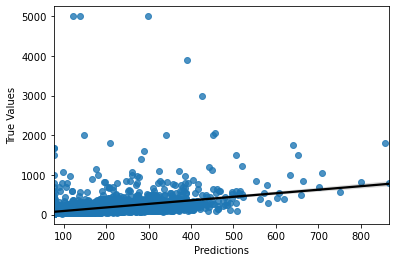

In [15]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

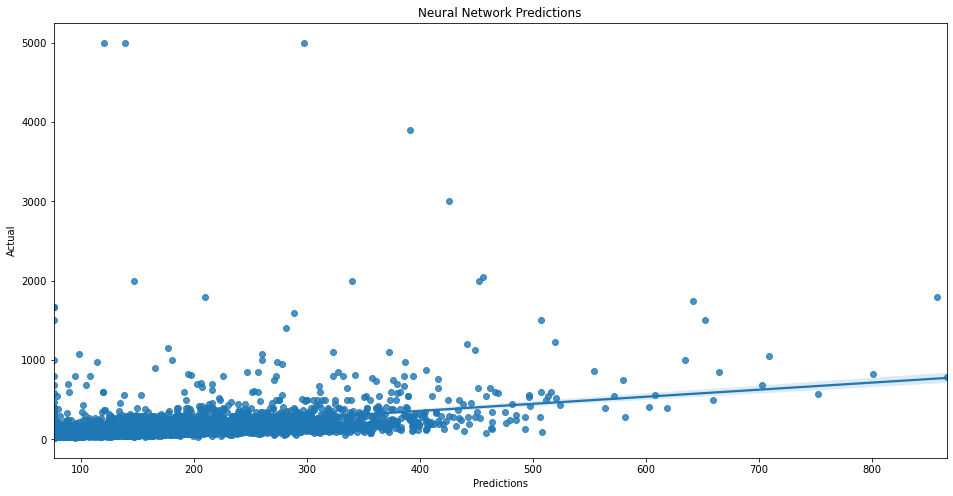

In [16]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group', title="NYC - NN price predictions", yaxis = dict(title ="Price"), xaxis =dict(title="Index"))
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [14]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 67.14
Root mean squared error: 168.38
Coefficient of determination: 0.16



<h2>Neural Network - Ratings</h2>

In [17]:
listings_cleaned_price = pd.read_csv('listings_cleaned_price.csv')
listings_cleaned_price = listings_cleaned_price.dropna()
listings_cleaned_price = listings_cleaned_price.drop(listings_cleaned_price.index[listings_cleaned_price['review_scores_rating'] <= 40])

listings_cleaned_price

,name,description,neighborhood_overview,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_neighbourhood,host_listings_count,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1,42741,11970,1,8,14773,4,71,94,73,1.0,...,9.0,9.0,9.0,9.0,9.0,1,1,0,0,4.82
3,35868,39688,0,14,17570,3,2,98,169,1.0,...,10.0,10.0,10.0,8.0,10.0,1,1,0,0,0.01
4,22611,26559,0,22,11370,3,2,2,175,1.0,...,7.0,9.0,9.0,10.0,9.0,1,0,1,0,3.42
5,13609,25182,0,15,19364,1,77,98,415,1.0,...,10.0,10.0,10.0,10.0,10.0,1,0,1,0,0.88
6,15820,18908,0,16,10621,3,2,15,226,4.0,...,9.0,10.0,10.0,9.0,9.0,4,2,0,2,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45538,24255,14660,0,1301,3439,4,2,81,116,1.0,...,10.0,10.0,10.0,10.0,10.0,5,1,3,1,1.00
45566,36791,15694,0,3939,20198,1,77,2,461,0.0,...,10.0,10.0,10.0,10.0,10.0,1,1,0,0,1.00
45568,13646,4153,1,1668,276,4,2,90,449,0.0,...,6.0,10.0,6.0,10.0,10.0,2,0,2,0,1.00
45576,24920,28959,0,1772,4627,4,2,71,10,1.0,...,10.0,10.0,10.0,10.0,10.0,1,1,0,0,1.00


In [18]:
X = listings_cleaned_price.copy()
y = X.pop('review_scores_rating')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 45)                2070      
_________________________________________________________________
dense_5 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_6 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [20]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)
y_preds = np.round(nn.predict(X_test), decimals=2)

Epoch 1/100
761/761 [==============================] - 0s 537us/step - loss: 81154760.0000 - mean_squared_error: 81154760.0000
Epoch 2/100
761/761 [==============================] - 0s 552us/step - loss: 94492952.0000 - mean_squared_error: 94492952.0000
Epoch 3/100
761/761 [==============================] - 0s 527us/step - loss: 34125676.0000 - mean_squared_error: 34125676.0000
Epoch 4/100
761/761 [==============================] - 0s 527us/step - loss: 101761.2422 - mean_squared_error: 101761.2422
Epoch 5/100
761/761 [==============================] - 0s 549us/step - loss: 182849.0312 - mean_squared_error: 182849.0312
Epoch 6/100
761/761 [==============================] - 0s 527us/step - loss: 3093180.2500 - mean_squared_error: 3093180.2500
Epoch 7/100
761/761 [==============================] - 0s 575us/step - loss: 994361.0000 - mean_squared_error: 994361.0000
Epoch 8/100
761/761 [==============================] - 0s 537us/step - loss: 588702.6875 - mean_squared_error: 588702.6875
Ep

761/761 [==============================] - 0s 510us/step - loss: 34.2632 - mean_squared_error: 34.2632
Epoch 69/100
761/761 [==============================] - 0s 528us/step - loss: 34.2582 - mean_squared_error: 34.2582
Epoch 70/100
761/761 [==============================] - 0s 533us/step - loss: 32.1017 - mean_squared_error: 32.1017
Epoch 71/100
761/761 [==============================] - 0s 645us/step - loss: 36.8749 - mean_squared_error: 36.8749
Epoch 72/100
761/761 [==============================] - 0s 561us/step - loss: 31.9992 - mean_squared_error: 31.9992
Epoch 73/100
761/761 [==============================] - 0s 533us/step - loss: 32.4937 - mean_squared_error: 32.4937
Epoch 74/100
761/761 [==============================] - 0s 550us/step - loss: 34.5180 - mean_squared_error: 34.5180
Epoch 75/100
761/761 [==============================] - 0s 523us/step - loss: 34.1791 - mean_squared_error: 34.1791
Epoch 76/100
761/761 [==============================] - 0s 562us/step - loss: 34.1926

Predicted Price Range:  40.86 106.37
Actual Price Range:  50.0 100.0


,Actual Values,Predicted Values
0,97.0,94.410004
1,95.0,94.449997
2,98.0,93.680000
3,90.0,90.160004
4,100.0,95.809998
5,92.0,92.260002
6,99.0,95.320000
7,100.0,96.470001
8,98.0,92.919998
9,97.0,94.529999


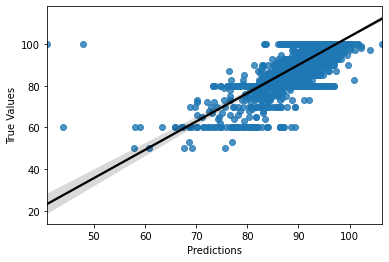

In [21]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

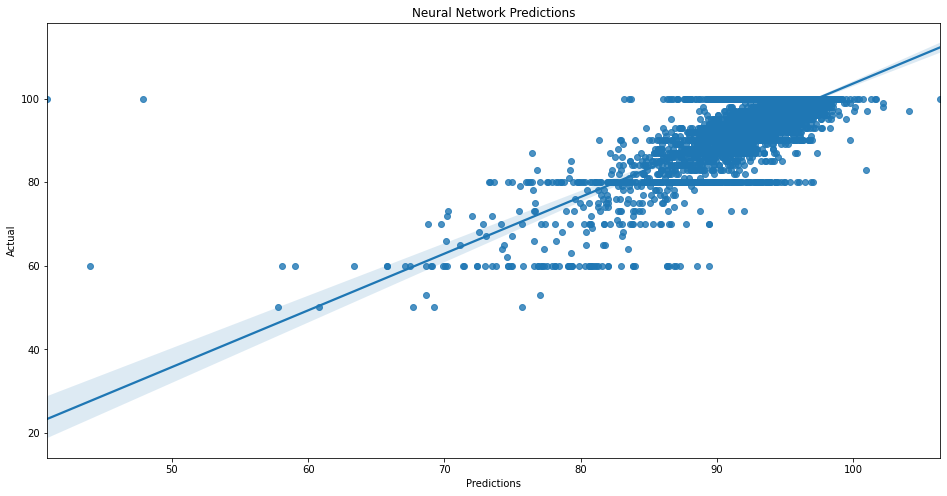

In [22]:
title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group', title="NYC - NN rating predictions", yaxis = dict(title ="Rating"), xaxis =dict(title="Index"))
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [21]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 3.84
Root mean squared error: 5.58
Coefficient of determination: 0.43

